# Regression of DDMC clusters against AXL gene and protein expression levels

In [106]:
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cross_decomposition import PLSRegression
from sklearn.linear_model import MultiTaskLassoCV, LassoCV
from msresist.pre_processing import filter_NaNpeptides
from sklearn.preprocessing import StandardScaler
from msresist.figures.figureM4 import drop_unmatched_cols
from msresist.figures.figure2 import plotR2YQ2Y

In [107]:
sns.set(style="whitegrid", font_scale=1.2, color_codes=True, palette="colorblind", rc={"grid.linestyle": "dotted", "axes.linewidth": 0.6})

### DDMC clusters

In [2]:
X = pd.read_csv("msresist/data/MS/CPTAC/CPTAC-preprocessedMotfis.csv").iloc[:, 1:]
X = filter_NaNpeptides(X, tmt=2)

with open('msresist/data/pickled_models/binomial/CPTACmodel_BINOMIAL_CL24_W15_TMT2', 'rb') as p:
    model = pickle.load(p)[0]

### AXL RNA and protein expression levels 

In [159]:
rna = pd.read_csv("msresist/data/MS/CPTAC/CPTAC_LUAD_RNAseq.csv")
protein = pd.read_csv("msresist/data/MS/CPTAC/CPTAC_LUAD_Protein.csv")

axlR = rna[rna["geneSymbol"] == "AXL"]
axlP = protein[protein["geneSymbol"] == "AXL"]

colsR = sorted(list(axlR.columns[6:]))
axlR = axlR[colsR]

colsP = sorted(list(axlP.columns[17:]))
axlP = axlP[colsP]

# Assert headers match between RNA and protein
assert not [s for s in colsR + colsP if s not in colsR or s not in colsP]

# Merge. Note that protein expression contains NaN values 
exp = pd.concat([axlR, axlP]).T.reset_index()
exp.columns = ["Patient_ID", "RNA", "Protein"]
expD = exp.dropna(axis=0)

/Users/creixell/Library/Python/3.9/lib/python/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (0,1,2,9,10,11,12,14,15,16) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Align cluster and expression samples

In [160]:
centers = pd.DataFrame(model.transform()).T
centers.iloc[:, :] = StandardScaler(with_std=False).fit_transform(centers.iloc[:, :])
centers = centers.T
centers.columns = np.arange(model.ncl) + 1
centers.insert(0, "Patient_ID", X.columns[4:])
centers = centers.sort_values(by="Patient_ID")
centersD = drop_unmatched_cols(list(centers["Patient_ID"]), list(expD["Patient_ID"]), centers, "Patient_ID")
centers = drop_unmatched_cols(list(centers["Patient_ID"]), list(exp["Patient_ID"]), centers, "Patient_ID")
expD = expD.set_index("Patient_ID")
exp = exp.set_index("Patient_ID")

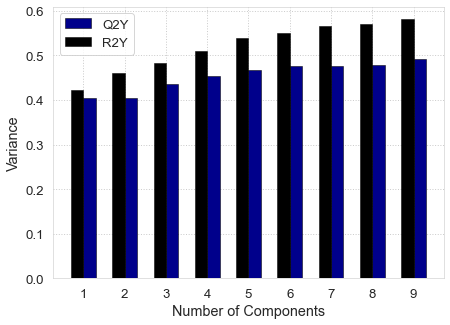

In [162]:
plsr = PLSRegression(n_components=4)

_, ax = plt.subplots(1, 1, figsize=(7, 5))
plotR2YQ2Y(ax, plsr, centersD, expD, b=10, color="darkblue")

0.5778119526943442


<AxesSubplot:xlabel='Cluster', ylabel='Coef'>

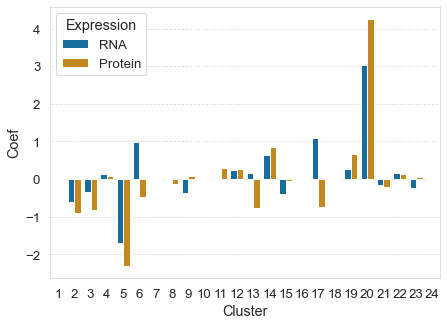

In [168]:
lasso = MultiTaskLassoCV(tol=0.00000001, max_iter=100000).fit(centersD, expD)
print(lasso.score(centersD, expD))

df = pd.DataFrame()
df["Coef"] = list(lasso.coef_[0]) + list(lasso.coef_[1])
df["Cluster"] = list(np.arange(model.ncl) + 1) + list(np.arange(model.ncl) + 1)
df["Expression"] = ["RNA"] * model.ncl + ["Protein"] * model.ncl

_, ax = plt.subplots(1, 1, figsize=(7, 5))
sns.barplot(data=df, x="Cluster", y="Coef", hue="Expression", ax=ax)

0.6132110980020885


<AxesSubplot:xlabel='Cluster', ylabel='Coef'>

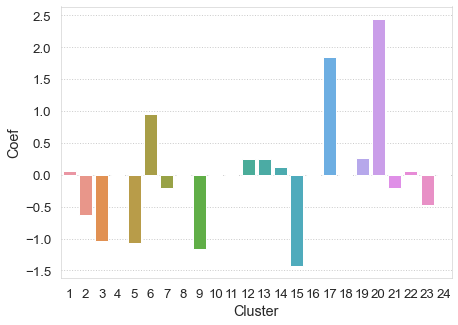

In [167]:
lasso = LassoCV(tol=0.00000001, max_iter=100000).fit(centers, exp.iloc[:, 0])
print(lasso.score(centers, exp.iloc[:, 0]))

df = pd.DataFrame()
df["Coef"] = list(lasso.coef_)
df["Cluster"] = list(np.arange(model.ncl) + 1)

_, ax = plt.subplots(1, 1, figsize=(7, 5))
sns.barplot(data=df, x="Cluster", y="Coef", ax=ax)